In [1]:
import numpy as np
import argparse

import torch
import matplotlib.pyplot as plt
import os

from Trainer.maskgit import MaskGIT
from Data import GS_DataModule

from arguments.args import Args
import matplotlib.colors as mcolors
from tqdm import tqdm

In [2]:
PATH = "lightning_logs/shapesplat_chairs/2c_windowed"

config_path = os.path.join(PATH, "config.yaml")
checkpoint_path = os.path.join(PATH, "checkpoints", "model.ckpt")

In [3]:
args = Args(config_path)

In [5]:
maskgit = MaskGIT.load_from_checkpoint(checkpoint_path=checkpoint_path, args=args, strict=False)

/scratch/foo22/miniconda3/envs/mg/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['vit.pos_emb', 'vit.bias']


In [7]:
maskgit = maskgit.eval()

In [8]:
rainbow_cmap = plt.cm.rainbow
colors = np.vstack(
    (
        rainbow_cmap(np.linspace(0, 1, 1024)),
        np.array([[0, 0, 0, 1]]),
        np.array([[1, 1, 1, 1]]),
    )
)
custom_cmap = mcolors.ListedColormap(colors)

def plot(gc):
    img = gc.reshape(32, 32, 32)
    for i in range(32):
        plt.subplot(4, 8, i+1)
        plt.imshow(img[i], cmap=custom_cmap, vmin=0, vmax=1025)
        # plt.axis('off')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

def plot_with_mask(gc, mask):
    # print(mask.shape, gc.shape)
    gc[np.array(mask, dtype=bool)] = 1024
    gc = gc.reshape(32, 32, 32)
    for i in range(32):
        plt.subplot(4, 8, i+1)
        plt.imshow(gc[i], cmap=custom_cmap, vmin=0, vmax=1025)
        # plt.axis('off')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

## Show Dataset Example

In [9]:
data_module = GS_DataModule(codebook_size=args.vqvae.codebook_n, **args.data.ka)

In [10]:
data_module.train_dataset[0].shape

(32768,)

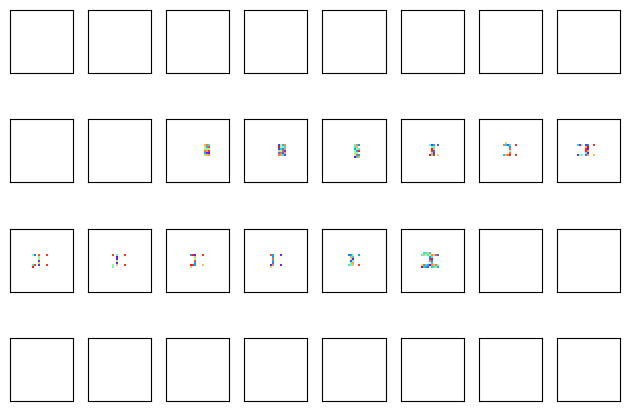

In [11]:
plot(data_module.train_dataset[0])
# print(data_module.dataset[0][0].flatten())

# Generate an Unconditional Sample

In [14]:
sm_temp = 1.0          # Softmax Temperature
r_temp = 4.5             # Gumbel Temperature
w = 0                  # Classifier Free Guidance
randomize = "linear"   # Noise scheduler
step = 128             # Number of step
sched_mode = "cosine"  # Mode of the scheduler

gen_sample, gen_code, l_mask = maskgit.sample(nb_sample=1, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step, with_replacement=False)

  0%|          | 0/128 [00:00<?, ?it/s]/scratches/gwangban/foo22/git/transformer-predictor/Trainer/maskgit.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # half precision


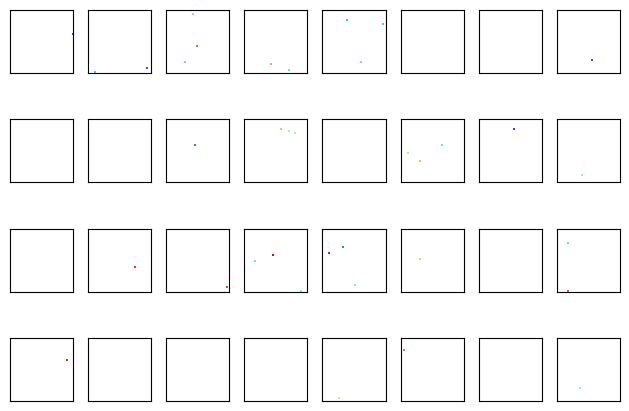

tensor([1025, 1025, 1025,  ..., 1025, 1025, 1025], device='cuda:0')


In [15]:
plot(gen_sample.detach().cpu().numpy())
print(gen_sample.flatten())

In [ ]:
raise ValueError()

## Generate 100 Samples and Save Them to File

In [43]:
N_SAMPLES=10
BATCH=1

In [44]:
generated_samples = np.zeros((N_SAMPLES, np.prod(maskgit.datum_shape)), dtype=np.int64)
for i in tqdm(range(N_SAMPLES // BATCH)):
    gen_sample = None
    while gen_sample is None or torch.all(gen_sample == maskgit.args.vit.empty_value):
        gen_sample, _, _ = maskgit.sample(nb_sample=BATCH, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step, with_replacement=False)
        gen_sample = gen_sample.flatten()
        generated_samples[i*BATCH:(i+1)*BATCH] = gen_sample.view(BATCH, -1).detach().cpu().numpy()

100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


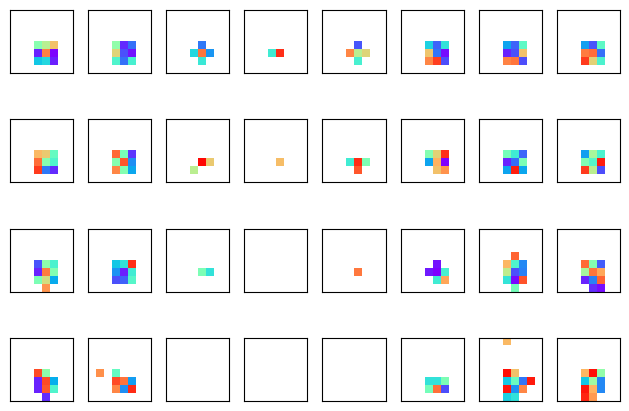

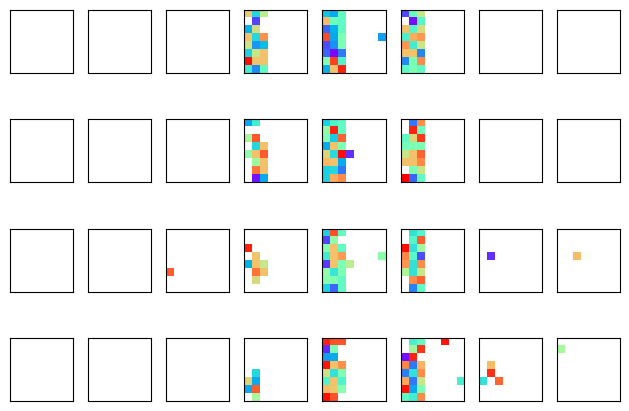

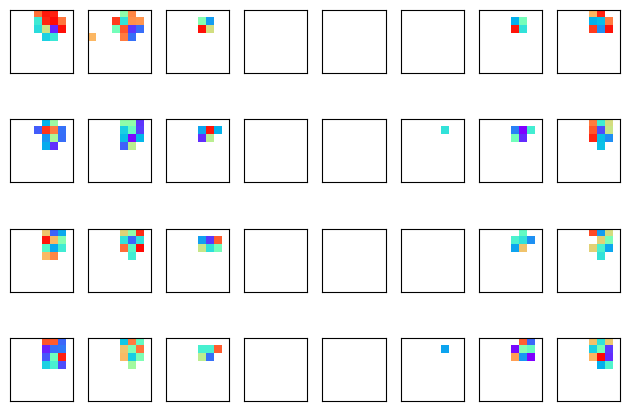

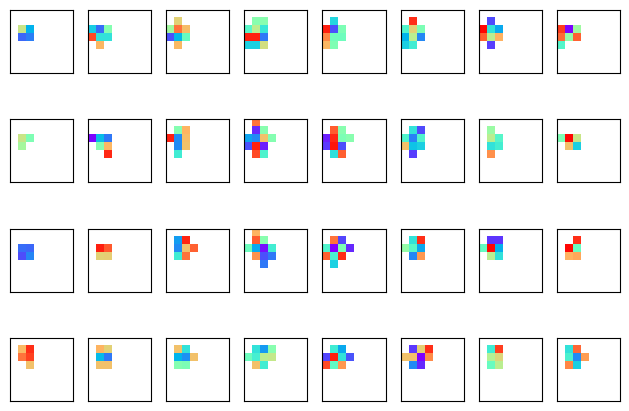

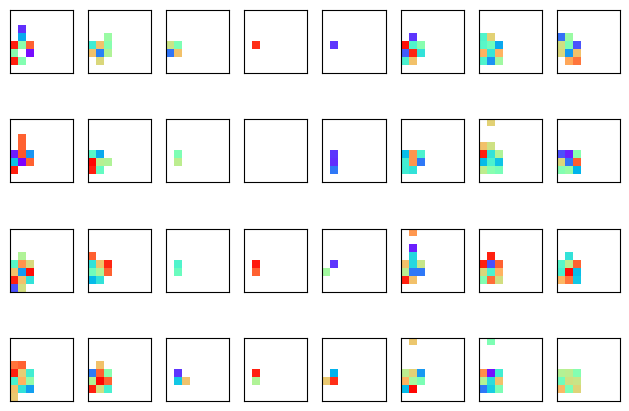

In [45]:
for i in range(5):
    plot(generated_samples[i])

In [46]:
OUTPUT_PATH = "/scratch/foo22/Data/Physics_Simulation/intermediate_data/generated_samples/four_dimensional_samples/"

In [47]:
os.makedirs(OUTPUT_PATH, exist_ok=True)
np.save(os.path.join(OUTPUT_PATH, "unconditional.npy"), generated_samples)

# Generate a Conditional Sample

torch.Size([32, 32, 32])


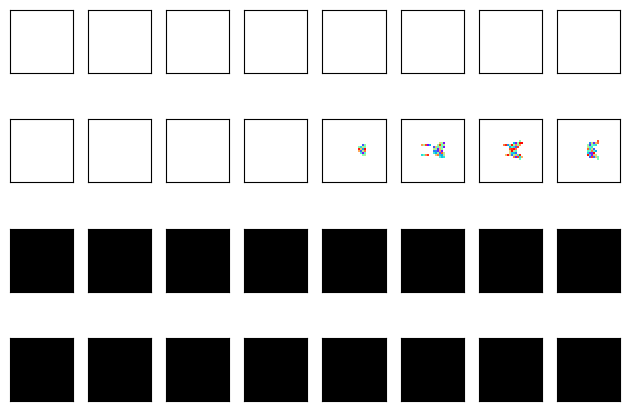

In [21]:
init_code = torch.from_numpy(data_module.train_dataset[2]).cuda()
init_code = init_code.view(*maskgit.datum_shape)
print(init_code.shape)
# init_code[torch.rand(init_code.shape)>0.1] = maskgit.args.vit.mask_value
init_code[16:] = maskgit.args.vit.mask_value

init_code = init_code.view(1, -1)

plot(init_code.detach().cpu())

In [22]:
sm_temp = 1.0          # Softmax Temperature
r_temp = 4.5             # Gumbel Temperature
w = 0                  # Classifier Free Guidance
randomize = "linear"   # Noise scheduler
step = 128              # Number of step
sched_mode = "cosine"  # Mode of the scheduler

gen_sample, gen_code, l_mask = maskgit.sample(init_code=init_code.clone(), nb_sample=1, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step, with_replacement=False)

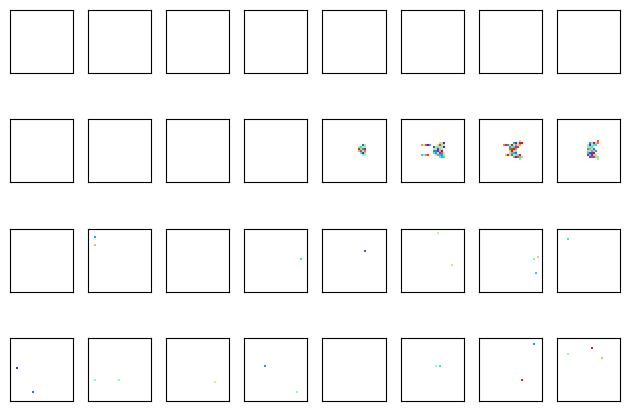

tensor([1025, 1025, 1025,  ..., 1025, 1025, 1025], device='cuda:0')


In [23]:
plot(gen_sample.detach().cpu().numpy())
print(gen_sample.flatten())

In [29]:
N_STARTERS = 10
N_SAMPLES = 10

val_ds_indices = np.random.randint(0, len(data_module.val_dataset), N_STARTERS)
samples = np.zeros([N_STARTERS, N_SAMPLES+1, np.prod(maskgit.datum_shape)])
for ds_idx in range(N_STARTERS):
    samples[ds_idx, 0] = data_module.val_dataset[val_ds_indices[ds_idx]].flatten()
    init_code = torch.from_numpy(data_module.val_dataset[ds_idx]).cuda()
    init_code = init_code.view(*maskgit.datum_shape)
    init_code[1:] = maskgit.args.vit.mask_value
    init_code = init_code.view(1, -1)
    for sample_nr in range(N_SAMPLES):
        gen_sample, gen_code, l_mask = maskgit.sample(init_code=init_code.clone(), nb_sample=1, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step, with_replacement=False)
        samples[ds_idx, sample_nr+1] = gen_sample.flatten().detach().cpu().numpy()


(10, 11, 2048)


  0%|          | 0/32 [00:00<?, ?it/s]

/scratches/gwangban/foo22/git/transformer-predictor/Trainer/maskgit.py:323: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # half precision


In [31]:
np.save(os.path.join(OUTPUT_PATH, "conditional.npy"), samples)